# Best Model (SVM)


## Setup and Data Loading
In this section, we:
- Import required libraries
- Load and prepare our Darija dataset
- Set up configuration parameters

In [1]:
import os 
os.chdir('/kaggle/input/ma-datasets') 
current_directory = os.getcwd()
print("Current working directory:", current_directory)
contents = os.listdir()
print("Directory contents:", contents)

Current working directory: /kaggle/input/ma-datasets
Directory contents: ['suf_pref_darija.json', 'stop_words_accum.json', 'set2.csv', 'set7.csv', 'set5.csv', 'Traditional-Arabic.ttf', 'darija_latin_ref.json', 'set4.csv', 'scaped_comments.csv', 'set3.csv', 'cleaned_clustered_data.csv', 'set1.csv']


In [2]:
!pip install pandas PyArabic Tashaphyne pydoda Arabic-Stopwords seaborn scikit-learn emoji xgboost lightgbm 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 18.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import re
from tashaphyne.stemming import ArabicLightStemmer
import json
import emoji 


In [4]:
df = pd.read_csv("/kaggle/input/dataset/dataset (18).csv")

In [5]:
df.head()

,text,target,text_cleaned
0,كما هو الشان بكل المدن العثيقه باليونان مدن قد...,1,شان عثيقه قديمه جميله محلاتوبيوت عباره ديافه
1,عدد الكشوفات لازالت قليلة,0,كشوف
2,اش هانكلو لخرا,0,لخرا هانكلو
3,الله يمسخكم مباغينش ترجعو لطريق الله الى جهنم...,0,جهنم وباس مباغينش يمسخكم مسير ترجعو
4,تفو عليك وعلي اليوم الي عرفتك فيه,0,تفو


In [6]:
df["target"].value_counts()

target
1    17500
0    17500
Name: count, dtype: int64

## Data Preprocessing
Key preprocessing steps for Darija text:
- Text cleaning and normalization
- Feature extraction
- Train-test split


In [7]:
darija_alphabet = {
    "gh": "غ",
    "sh": "ش",
    "ch": "ش",
    "ss": "س",
    "kh": "خ",
    "ç": "س",
    "ou": "و",    
    "ei": "ي",    
    "ay": "ي",    
    "ae": "ي",   
    "5": "خ",     
    "2": "ا",  
    "a": "ا",    
    "b": "ب",
    "t": "ت",
    "j": "ج",
    "7": "ح",
    "d": "د",
    "dd": "ض",
    "r": "ر",
    "z": "ز",
    "s": "س",
    "ss": "ص",
    "9": "ق",
    "3": "ع",
    "4": "غ",
    "f": "ف",
    "q": "ك",
    "k": "ك",
    "l": "ل",
    "m": "م",
    "n": "ن",
    "h": "ه",
    "w": "و",
    "y": "ي",
    "g": "ڭ",
    'i': 'ي',
    'ee': 'ي',
    'aa': 'ا',
    'oo': 'و',
    'o': 'و',
    "x": "ش",
}
word_in = [
    "ء", "أ", "إ", "آ", "ؤ", "ئ", "ة", "ى","-", "/", ".", "،", '"', "'", "\\", "?", "؟", "!", "،", "؛",":","#", "@", "&", "=", "¥", "$", "%", "*", "+", "<", ">", "|", "~", "^", 
    "\n", "\t", "\r", "ذ", "ظ",  "(", ")", "[", "]", "{", "}", "《", "》", "«", "»"
]

replaced_by = [
    "ا", "ا", "ا", "ا", "ا", "ا", "ه", "ي"," ", "", "", "", "", "", "", " ? ", " ؟ ", " ! ", "", "", "",
    "", "", "", "", "", "", "", "", "", "", "", "", "", ""," ", " ", " ", "",
    "د", "ض","",  "", "", "", "", "", "", "", ""
]

arabic_alphabet = "ابتثجحخدذرزسشصضطظعغفقكلمنهوي"

In [8]:
from pyarabic.araby import strip_diacritics
#remove tashkeel
def removing_tashkeel(word): # useed
          return strip_diacritics(word)

In [9]:
from pyarabic.araby import strip_tatweel

#remove tatweel l2imdad
def removing_tatweel(word): # useed
          return strip_tatweel(word)

In [10]:
from pyarabic.araby import normalize_ligature

#remove ligature hamza , alef 
def removing_ligature(word): # not used 
          return normalize_ligature(word)

In [11]:
# remove underscore
def replace_underscore(word): # useed
          return word.replace("_", " ")

In [12]:
import pyarabic.araby as araby

# remove hamza ambiguity
def remove_ambiguity_hamza(word): # useed
          return araby.normalize_hamza(word)

In [13]:
# romove "AL"
def remove_AL(word): # useed
          return re.sub(r'^ال', '', word)

In [14]:
# remove repeated characters      
def word_remover(word): # useed
            if len(word) == 1 or len(word) == 0 or len(word) >= 13:
                return ""                
            else :
                #print(word)
                for a7rf in arabic_alphabet:
                    if a7rf == 'د' or a7rf == 'ه':
                        word = re.sub(fr'{a7rf}{{3,}}', a7rf * 2, word).strip()
                    else:
                        word = re.sub(fr'{a7rf}+', a7rf, word).strip()
                #print(word) 
                for i in range(len(word)):
                    try:
                        if word[i] in word_in:
    
                                #print(word[i])
                                index = word_in.index(word[i])
                                #print("this is  the index : " + str(index))
                                #print("this is : " + replaced_by[index])
                                word = word[:i] + replaced_by[index] + word[i + 1:]
                    except IndexError:
                             if word[i-1] in word_in:
                                #print(word[i])
                                index = word_in.index(word[i])
                                #print("this is  the index : " + str(index))
                                #print("this is : " + replaced_by[index])
                                word = word[:i] + replaced_by[index] + word[i + 1:]

                return word


In [15]:
# remove emails  
def remove_url(text): # useed
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b',
                  '', text, flags=re.MULTILINE)
    return text      
 

In [16]:
 # remove emails     
def remove_emails(text): # useed
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text, flags=re.MULTILINE)
    return text  

In [17]:
def special_tags_and_ponctuations(text):  # Function to clean special tags
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'&quot;', '', text)  
    text = re.sub(r'!+', '!', text)
    text = re.sub(r'\?+', '?', text)
    text = re.sub(r'\.+', '.', text)

    return text

In [18]:
def remove_html_tags(text):
    text = re.sub(r'<[^>]+>', '', text)
    return text

In [19]:
# hundle emojis
def extend_spletting(items):  # helper function to split items
    spletting = []
    for item in items:
        spletting.extend(item.split())
    return spletting

In [20]:
def emoji_hundler(word):  # helper function to handle emojis
    word = emoji.demojize(word, language='ar')
    word = replace_underscore(word)[1:-1]
    return word

In [21]:
def is_an_emoji(word):
    emoji_pattern = re.compile("["  
                               u"\U0001F680-\U0001F6FF"  # transport and map unicods
                               u"\U0001F1E0-\U0001F1FF"  # flags unicods
                               "]+", flags=re.UNICODE)

    if emoji.is_emoji(word):
        word = emoji_pattern.sub(r'', word)
        return extend_spletting([emoji_hundler(word)])

    elif emoji.purely_emoji(word):
        data_of_emojis = emoji.distinct_emoji_list(word)
        data = [emoji_hundler(emoji_pattern.sub(r'', item)) for item in data_of_emojis]
        return extend_spletting(data)

    else:
        text_only = re.sub(r'[^\w\s?!]', '', word)
        data_of_emojis = emoji.distinct_emoji_list(word)
        emojis = [emoji_hundler(emoji_pattern.sub(r'', item)) for item in data_of_emojis]
        
        return [text_only] + extend_spletting(emojis)


In [22]:
# tramslating darija(latin) to daruja(arabic)
def translate_darija_to_arabic(word): # useed
    # print("test")
    word = word.lower()
    if  bool(re.compile(r"[a-z0-9']+").search(word)):
        arabic_word = ""
        i = 0
        while i < len(word):
            # print('sadd')
            if i + 1 < len(word) and word[i:i+2] in darija_alphabet: # Check for 2 lettrs
                arabic_word += darija_alphabet[word[i:i+2]]
                i += 2
            elif word[i] in darija_alphabet:
                arabic_word += darija_alphabet[word[i]]
                i += 1
            else:
                i += 1
        return arabic_word
    return word
      

In [23]:
# remove  number arabic and latin
def number_remov(listy): # useed
    number_pattern = re.compile(r'^[0-9\u0660-\u0669]+$')
    cleaned_list = [item for item in listy if not number_pattern.fullmatch(item)] 
    return cleaned_list   

In [24]:
#stemming arabic words     
def stemming_darija(word):
    # file = "./Data_prep/suf_pref_darija.json" # local run
    file = "suf_pref_darija.json" 

    with open(file, 'r', encoding='utf-8') as json_file:
        suf_pref = json.load(json_file)

    ArListem = ArabicLightStemmer()
    ArListem.set_prefix_list(suf_pref['darija_prefixes'])
    ArListem.set_suffix_list(suf_pref['darija_suffixes'])
    ArListem.light_stem(word)  
    return ArListem.get_stem() 

In [25]:
# "03:44"
def remove_yt_timers(text):
    pattern = r'\b\d{1,2}:\d{2,3}(:\d{2,3})?\b'
    text = re.sub(pattern, '', text)
    return text.strip()

In [26]:

def preproc_arab_sentence(word): # main function for  arab processing tokens
    word = removing_tashkeel(word)
    word = removing_tatweel(word)
    word = remove_AL(word)
    # word = remove_ambiguity_hamza(word)
    word = word_remover(word)
    return word


In [27]:
from pyarabic.araby import tokenize
def tokenize_arab_text(text):
            # with open('./Data_prep/stop_words_accum.json', 'r', encoding='utf-8') as file: #  local run 
            with open('./stop_words_accum.json', 'r', encoding='utf-8') as file:

                stop_words = json.load(file)

            # with open('./Data_prep/darija_latin_ref.json', 'r', encoding='utf-8') as file: #  local run 
            with open('./darija_latin_ref.json', 'r', encoding='utf-8') as file:
                
                darija_latin_ref = json.load(file)
          
            #print(text)
            text = remove_url(text)
            text = remove_emails(text)
            text = replace_underscore(text)
            text = remove_html_tags(text)
            text = remove_yt_timers(text)
            text = special_tags_and_ponctuations(text)
            #tokenization
            print(text)
            words = tokenize(text)
            print(words)
            words = [ translate_darija_to_arabic(word) for word in words if word not in darija_latin_ref]
            print(words)
            words = [is_an_emoji(word) for word in words] 
            words = [item for sublist in words for item in sublist if item]
            words = list(set(words))
            print(words)        
            words = [word for word in words if word not in stop_words]
            print(words)

            words = [preproc_arab_sentence(word) for word in words]

            print(words)        
            words = [stemming_darija(word) for word in words if word]
            words = number_remov(words)


            # print(words)
            words = ' '.join(words) 
            return words

In [28]:
tokenize_arab_text("خوك ضريف❤️")

خوك ضريف❤️
['خوك', 'ضريف', '❤️']
['خوك', 'ضريف', '❤️']
['قلب', 'أحمر', 'ضريف', 'خوك']
['قلب', 'أحمر', 'ضريف', 'خوك']
['قلب', 'احمر', 'ضريف', 'خوك']


'قلب احمر ضريف خوك'

In [29]:
df.head()

,text,target,text_cleaned
0,كما هو الشان بكل المدن العثيقه باليونان مدن قد...,1,شان عثيقه قديمه جميله محلاتوبيوت عباره ديافه
1,عدد الكشوفات لازالت قليلة,0,كشوف
2,اش هانكلو لخرا,0,لخرا هانكلو
3,الله يمسخكم مباغينش ترجعو لطريق الله الى جهنم...,0,جهنم وباس مباغينش يمسخكم مسير ترجعو
4,تفو عليك وعلي اليوم الي عرفتك فيه,0,تفو


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          35000 non-null  object
 1   target        35000 non-null  int64 
 2   text_cleaned  33821 non-null  object
dtypes: int64(1), object(2)
memory usage: 820.4+ KB


In [31]:
df.dropna(inplace=True)

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( df.drop(columns=["target"]),df["target"], test_size=0.2 , stratify=df['target'] ,shuffle=True , random_state=123)

In [33]:
# this  part  is  used to  make benchmarking with other models
test_data = X_test.copy() 
test_data['target'] = y_test  #

test_data.to_csv('/kaggle/working/test_data.csv', index=False)

In [34]:
y_test.value_counts()

target
0    3443
1    3322
Name: count, dtype: int64

In [35]:
X_train.shape

(27056, 2)

## Useful Function

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def about_model(model_name , y_test, y_pred):
    print('-------------------> ' + model_name )
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    
    f1 = f1_score(y_test, y_pred, average=None)
    print("F1-Score for each class:")
    class_labels = ['Positive', 'Negative']

    for i, score in enumerate(f1):
        print(f"{class_labels[i]}: {score:.2f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_labels, digits=2))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


## Feature Engineering
Converting text to vectors format:
- TF-IDF Vectorization (ngram_range=(1, 2))

In [37]:
#from sklearn.feature_extraction.text import TfidfVectorizer


#tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
#X_train['text_cleaned'] = X_train['text_cleaned'].astype(str)
#X_test['text_cleaned'] = X_test['text_cleaned'].astype(str)

#X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['text_cleaned'])
#X_test_tfidf = tfidf_vectorizer.transform(X_test['text_cleaned'])



In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd


tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

X_train['text_cleaned'] = X_train['text_cleaned'].astype(str)
X_test['text_cleaned'] = X_test['text_cleaned'].astype(str)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['text_cleaned'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['text_cleaned'])

words = tfidf_vectorizer.get_feature_names_out()
print("all tokens: " , len(words))
tfidf_scores = np.asarray(X_train_tfidf.sum(axis=0)).flatten()

sorted_indices = np.argsort(tfidf_scores)[::-1]

cumulative_tfidf = np.cumsum(tfidf_scores[sorted_indices])

total_tfidf = cumulative_tfidf[-1]
threshold =   total_tfidf

cutoff_index = np.where(cumulative_tfidf >= threshold)[0][0]

selected_ngrams = words[sorted_indices][:cutoff_index + 1]

selected_vocab = selected_ngrams.tolist()
print("reduced tokens: "  , len(selected_vocab))

tfidf_vectorizer = TfidfVectorizer(vocabulary=selected_vocab , min_df = 0.1)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['text_cleaned'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['text_cleaned'])


all tokens:  170889
reduced tokens:  170889


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1380: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [39]:
tfidf_vectorizer.get_feature_names_out()[:30]

array(['لا', 'ما', 'غير', 'هه', 'خير', 'حمد', 'مبروك', 'ماش', 'تفو',
       'سير', 'هم', 'قلب', 'فرح', 'عداله', 'احسن', 'لم', 'وفي', 'فكر',
       'عديم', 'قوه', 'بدموع', 'طحن', 'تنميه', 'تحيه', 'ليس', 'والو',
       'كورو', 'سح', 'تبارك', 'دل'], dtype=object)

In [40]:
len(tfidf_vectorizer.get_feature_names_out())

170889

## Model 


In [41]:
from sklearn.svm import SVC
svm_clf = SVC(probability=True)
svm_clf.fit(X_train_tfidf, y_train)

SVC(probability=True)

-------------------> SVM
Accuracy: 0.77
F1-Score for each class:
Positive: 0.78
Negative: 0.76

Classification Report:
              precision    recall  f1-score   support

    Positive       0.76      0.79      0.78      3443
    Negative       0.77      0.74      0.76      3322

    accuracy                           0.77      6765
   macro avg       0.77      0.77      0.77      6765
weighted avg       0.77      0.77      0.77      6765



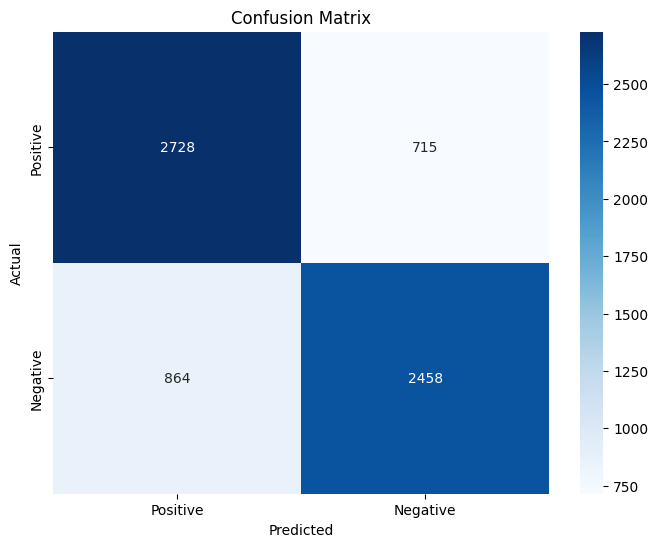

In [42]:
y_hat = svm_clf.predict(X_test_tfidf) 
about_model("SVM" , y_test, y_hat)

In [43]:
text = tokenize_arab_text('حلقة ليوم باسلة')
print(text)

if isinstance(text, str):
    text = [text]  

text_vectorized = tfidf_vectorizer.transform(text)  
text_vectorized = text_vectorized.reshape(1, -1)  
svm_clf.predict(text_vectorized)

حلقة ليوم باسلة
['حلقة', 'ليوم', 'باسلة']
['حلقة', 'ليوم', 'باسلة']
['حلقة', 'باسلة', 'ليوم']
['باسلة']
['باسله']
باسله


array([0])

In [44]:
!pip install wordcloud arabic_reshaper


In [45]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from bidi.algorithm import get_display
import arabic_reshaper

In [46]:
positive_texts = ' '.join(df[df['target'] == 1]['text_cleaned'])
negative_texts = ' '.join(df[df['target'] == 0]['text_cleaned'])

In [47]:
def generate_arabic_wordcloud(text, title, color='white', background_color='black'):
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    
    wordcloud = WordCloud(
        font_path='/kaggle/input/ma-datasets/Traditional-Arabic.ttf', 
        width=800,
        height=400,
        background_color=background_color,
        color_func=lambda *args, **kwargs: color,
        prefer_horizontal=0.7
    ).generate(bidi_text)
    
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

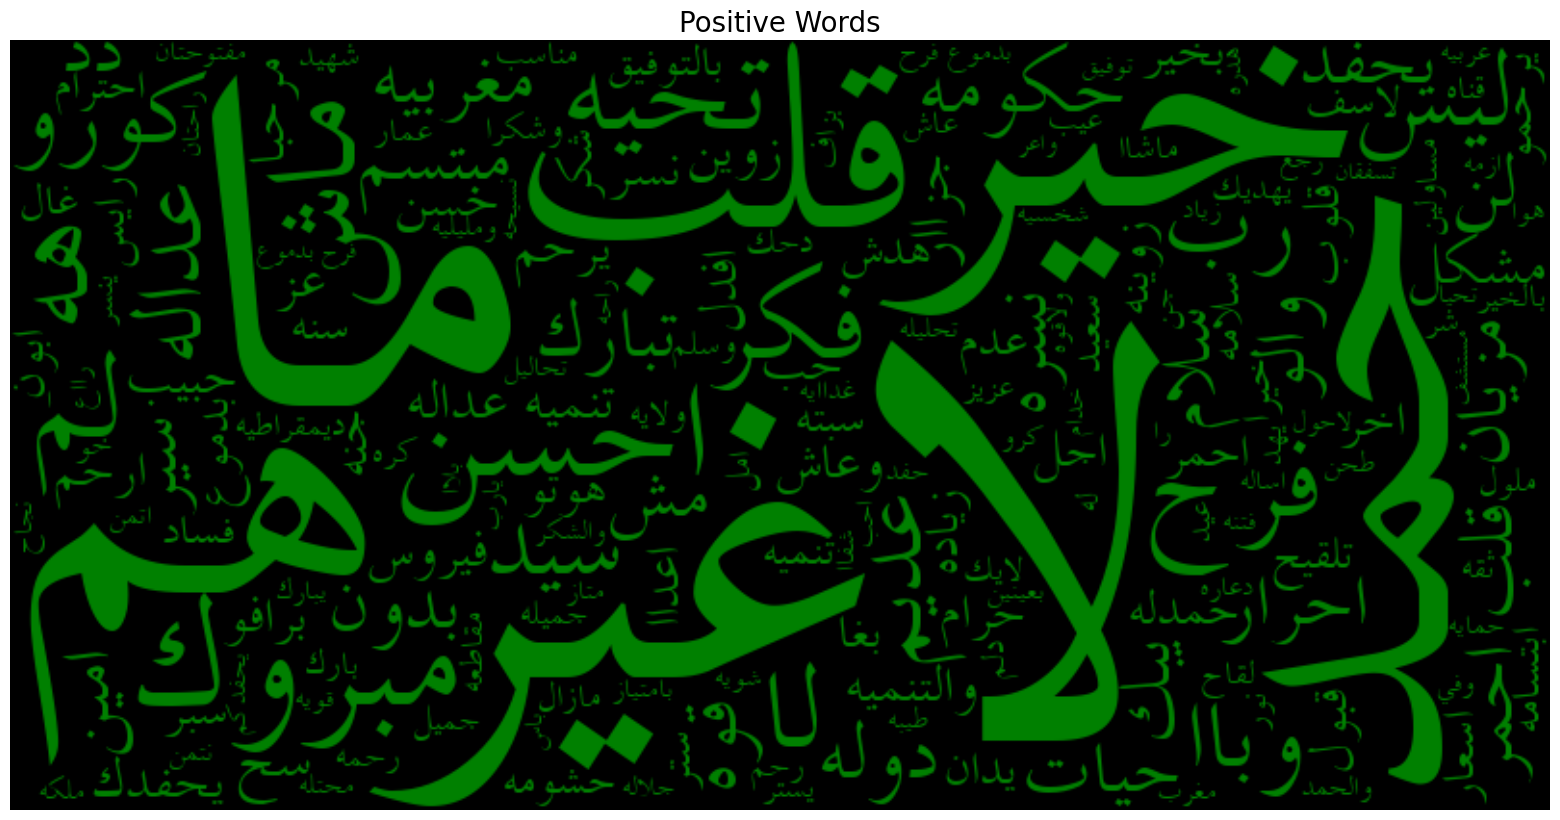

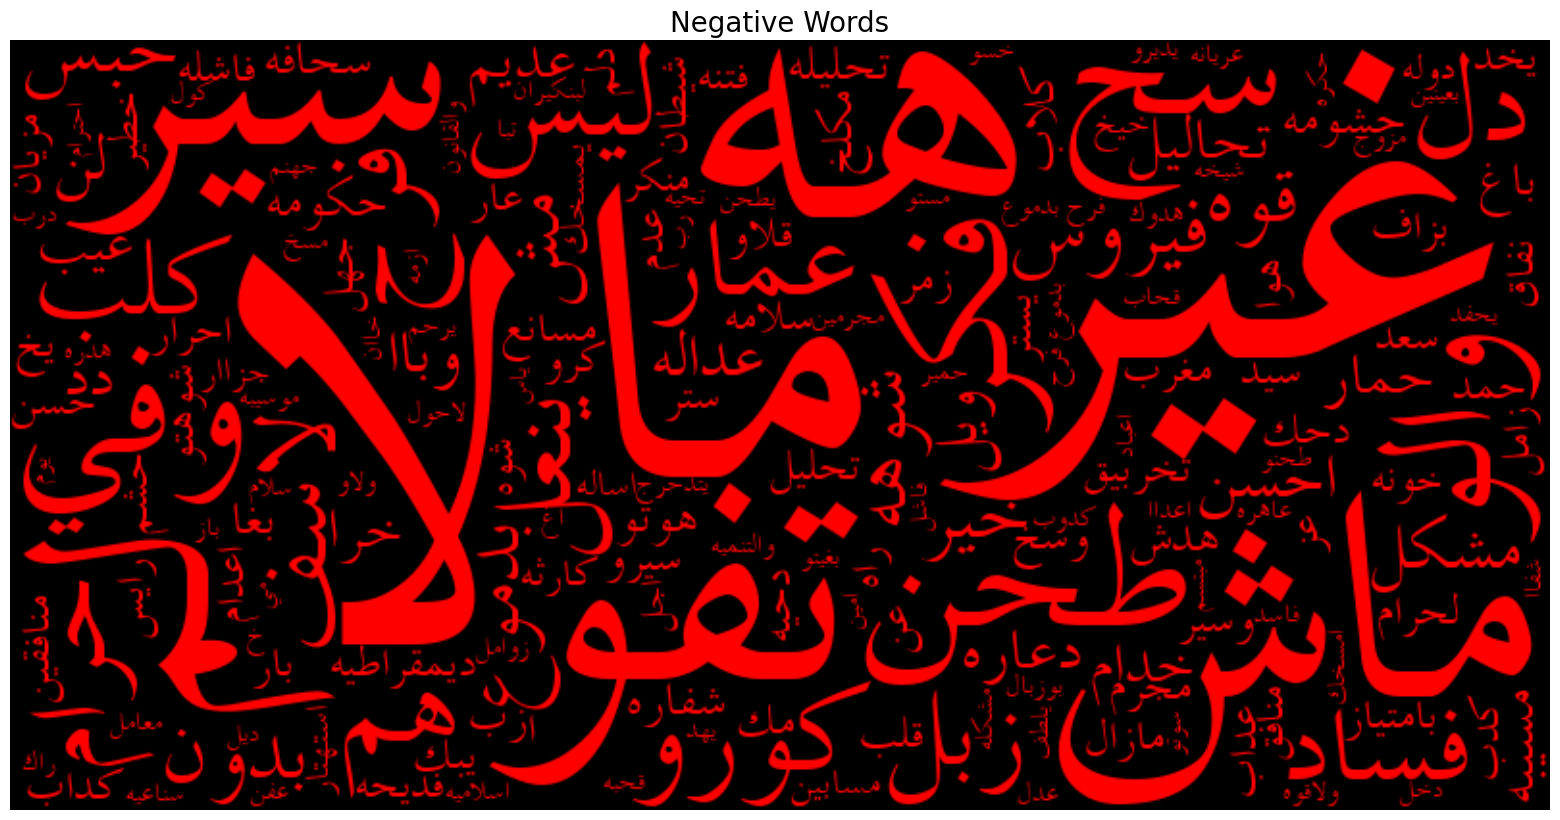

In [48]:

# Positive word cloud
generate_arabic_wordcloud(positive_texts, 'Positive Words', color='green', background_color='black')

# Negative word cloud
generate_arabic_wordcloud(negative_texts, 'Negative Words', color='red', background_color='black')



In [49]:
from collections import Counter
import re

def get_top_words(text, n=20):
    words = text.split()
    return Counter(words).most_common(n)

print("\nTop 20 Positive Words:")
print(get_top_words(positive_texts))

print("\nTop 20 Negative Words:")
print(get_top_words(negative_texts))


Top 20 Positive Words:
[('لا', 1399), ('ما', 955), ('غير', 749), ('قلب', 582), ('حمد', 547), ('خير', 528), ('هم', 494), ('مبروك', 372), ('عداله', 329), ('احسن', 310), ('فرح', 290), ('ماش', 287), ('تحيه', 265), ('عديم', 261), ('هه', 249), ('قوه', 228), ('لم', 217), ('احمر', 209), ('فكر', 208), ('تنميه', 188)]

Top 20 Negative Words:
[('لا', 1711), ('غير', 1309), ('ما', 1164), ('هه', 858), ('تفو', 593), ('ماش', 568), ('سير', 523), ('لم', 349), ('فرح', 250), ('طحن', 247), ('وفي', 243), ('سح', 239), ('بدموع', 225), ('فكر', 209), ('والو', 203), ('قوه', 196), ('دل', 186), ('ليس', 185), ('كورو', 183), ('عداله', 183)]
